# Quick exploration with EDA-5 mini dataset - Mosaic of ~100x100 chunks - RAW data (`mask_and_scale` off)

In [1]:
import os
import json 
import subprocess
import importlib

import numpy as np
import xbitinfo as xb
import xarray as xr

import utils

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

In [3]:
# load data
path_to_data = 'data/data-t2m-sp-tp-2023-mai-0112.nc'  # change this
ds = xr.open_dataset(path_to_data, mask_and_scale=False)

In [4]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2023-05-01T12:00:00
Data variables:
    t2m        (time, latitude, longitude) int16 ...
    sp         (time, latitude, longitude) int16 ...
    tp         (time, latitude, longitude) int16 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-15 22:53:25 GMT by grib_to_netcdf-2.30.0: grib_to_n...

<Axes: title={'center': 'Statistical distributions'}, xlabel='value', ylabel='Probability density'>

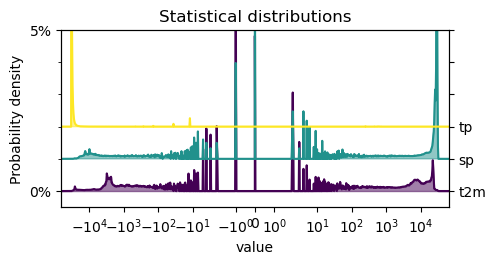

In [5]:
xb.plot_distribution(ds)

In [6]:
ds.t2m.data = ds.t2m.data.view(np.float16)
ds.tp.data = ds.tp.data.view(np.float16)
ds.sp.data = ds.sp.data.view(np.float16)

/home/ayoubf/miniconda3/envs/bitinfo/lib/python3.11/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ayoubf/miniconda3/envs/bitinfo/lib/python3.11/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start
/home/ayoubf/miniconda3/envs/bitinfo/lib/python3.11/site-packages/numpy/lib/function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


ValueError: Axis limits cannot be NaN or Inf

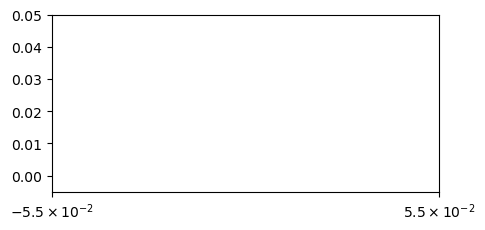

In [7]:
xb.plot_distribution(ds)

In [8]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2023-05-01T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float16 -1.633e+04 ... -0.003071
    sp         (time, latitude, longitude) float16 2.8e+04 2.8e+04 ... -163.9
    tp         (time, latitude, longitude) float16 -1.788e-06 ... -2.384e-07
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-15 22:53:25 GMT by grib_to_netcdf-2.30.0: grib_to_n...

In [9]:
# get information content per bit
info_per_bit = xb.get_bitinformation(ds, dim="latitude", implementation="python")

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
fig = xb.plot_bitinformation(info_per_bit)

AssertionError: currently only works properly for float32 data, looking forward to your PR closing https://github.com/observingClouds/xbitinfo/issues/168

In [12]:
# get keepbits
keepbits = xb.get_keepbits(info_per_bit, 0.99)

In [13]:
# apply bitrounding
ds_bitrounded = xb.xr_bitround(ds, keepbits)

---

In [14]:
at_least_zero = lambda x: max(x, 0)

In [15]:
chunk_long, chunk_lat = [120, 103] # for int division
vrbs = ['longitude', 'latitude']
var = 'latitude'

dss = []
dss_bitrounded = []
dss_kbits = []

long_c = int(ds.longitude.size / chunk_long)
lat_c = int(ds.latitude.size / chunk_lat)


for i in range(long_c):
    for j in range(lat_c):
        temp_ds = ds.isel(longitude=slice(i*chunk_long, (i+1)*chunk_long),
                          latitude=slice(j*chunk_lat, (j+1)*chunk_lat))
        dss.append(temp_ds)
        temp_info_pbit = xb.get_bitinformation(temp_ds, dim=var, implementation="python")
        # fig = xb.plot_bitinformation(temp_info_pbit)
        temp_keepbits = xb.get_keepbits(temp_info_pbit, 0.99)
        # cope with negative keepbits
        temp_keepbits = temp_keepbits.map(at_least_zero)
        dss_kbits.append(temp_keepbits)
        temp_ds_bitrounded = xb.xr_bitround(temp_ds, temp_keepbits)
        dss_bitrounded.append(temp_ds_bitrounded)
        
    #     if j == 0: break
    # if i == 0: break

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

---

/home/ayoubf/miniconda3/envs/bitinfo/lib/python3.11/site-packages/matplotlib/colors.py:1354: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/home/ayoubf/miniconda3/envs/bitinfo/lib/python3.11/site-packages/matplotlib/colors.py:1354: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


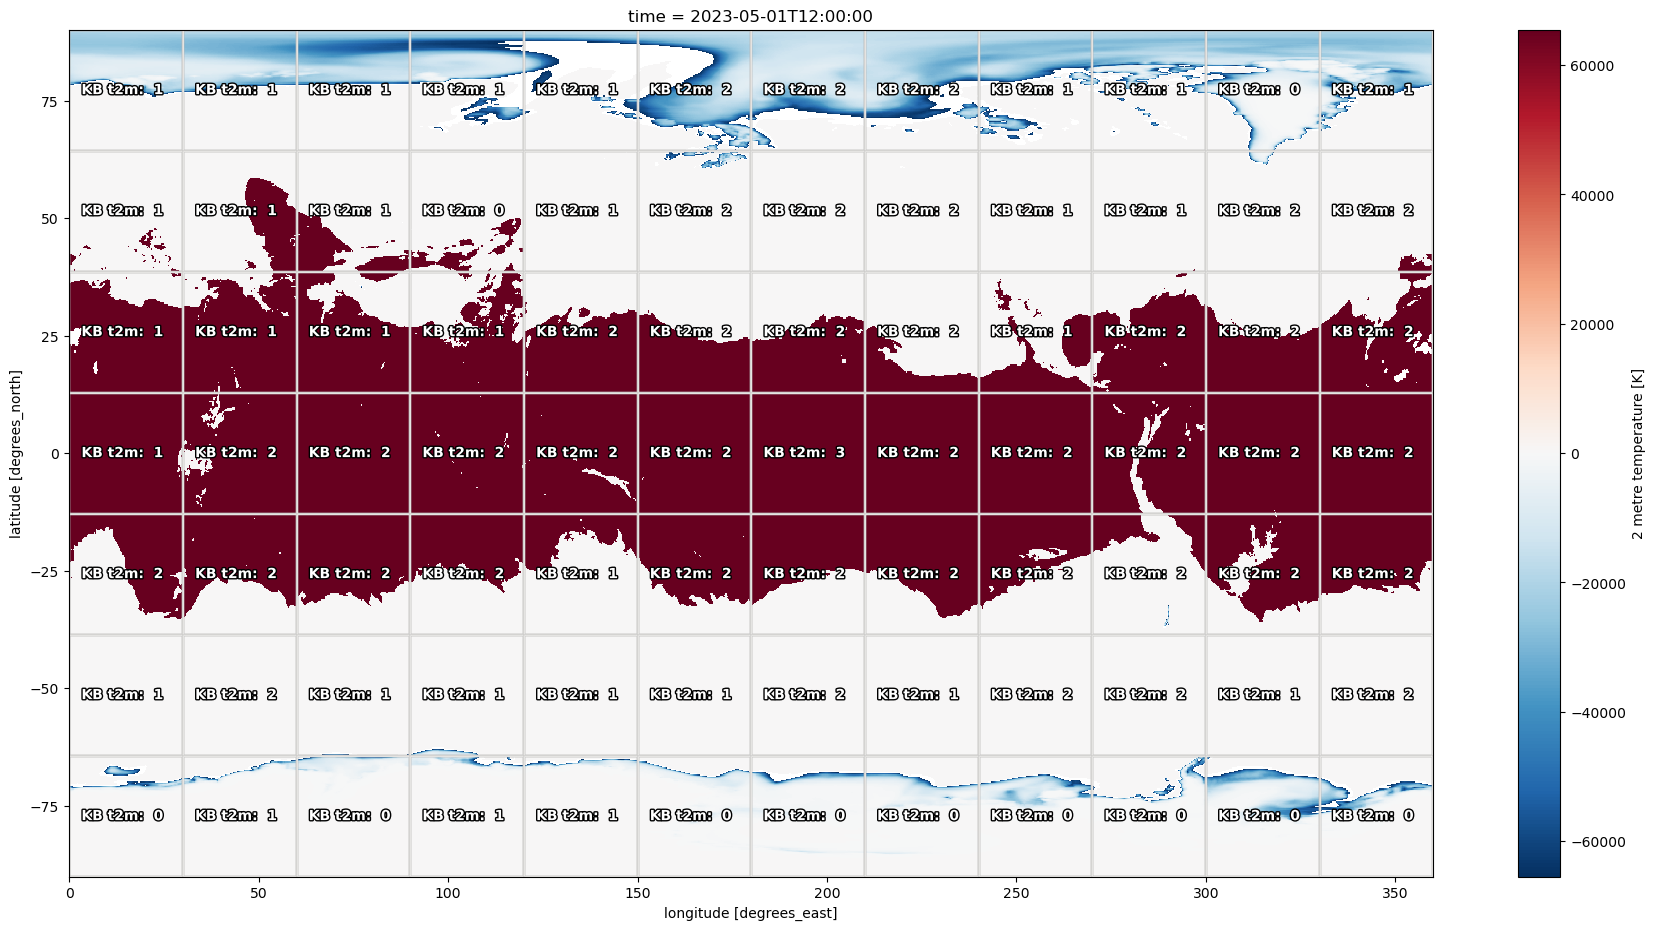

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

fig, ax = plt.subplots(figsize=(22, 11))
        
ds.isel(time=0)['t2m'].plot(ax=ax)

for i in range(len(dss_bitrounded)):
    x = float(min(dss[i].longitude[0], dss[i].longitude[-1]))
    y = float(min(dss[i].latitude[0], dss[i].latitude[-1]))
    w = float(abs(dss[i].longitude[0] - dss[i].longitude[-1]))
    h = float(abs(dss[i].latitude[0] - dss[i].latitude[-1]))
    rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                facecolor = "none", edgecolor = "#E5E4E2",
                                path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                label='xxx')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/2.0
    ax.annotate(
        f"""
        KB t2m: {int(dss_kbits[i].t2m):2}
        """,
        # I: X{ratios[i]['comp']}
        # II: X{ratios[i]['bitr_comp']}
        # """,
        (cx+10, cy), color='w', weight='bold', fontsize=10, ha='right', va='center',
        path_effects=[pe.withStroke(linewidth=2, foreground='k')]
    )

fig.show()

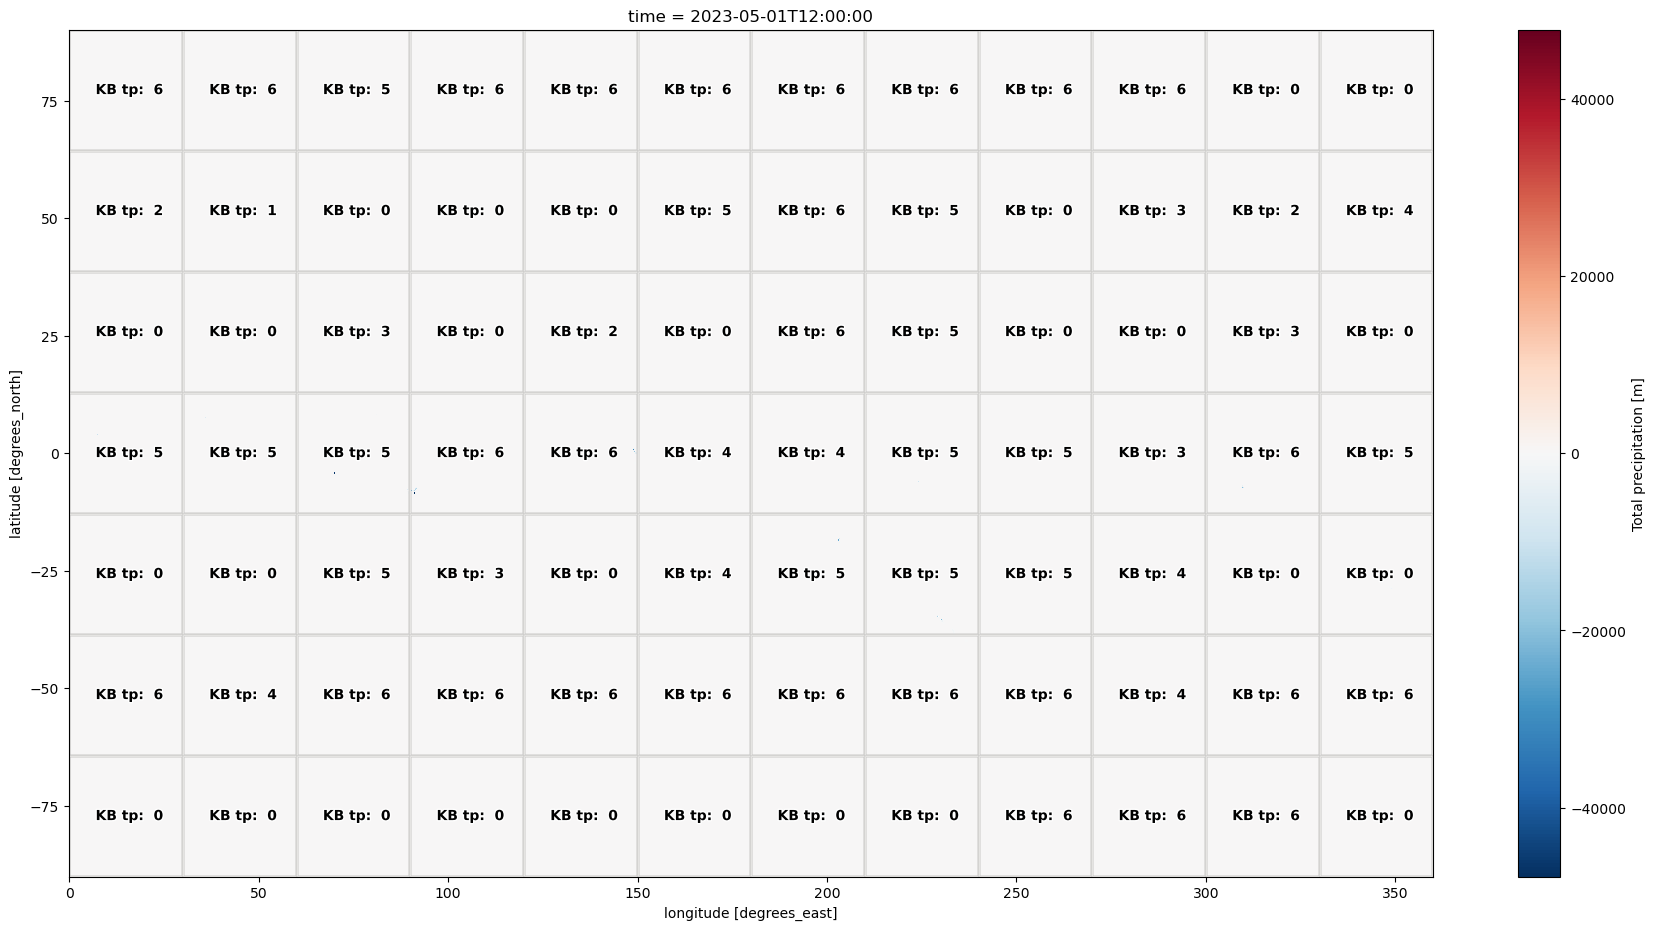

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

fig, ax = plt.subplots(figsize=(22, 11))
        
ds.isel(time=0)['tp'].plot(ax=ax)

for i in range(len(dss_bitrounded)):
    x = float(min(dss[i].longitude[0], dss[i].longitude[-1]))
    y = float(min(dss[i].latitude[0], dss[i].latitude[-1]))
    w = float(abs(dss[i].longitude[0] - dss[i].longitude[-1]))
    h = float(abs(dss[i].latitude[0] - dss[i].latitude[-1]))
    rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                facecolor = "none", edgecolor = "#E5E4E2",
                                path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                label='xxx')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/2.0
    ax.annotate(
        f"""
        KB tp: {int(dss_kbits[i].tp):2}
        """,
        # I: X{ratios[i]['comp']}
        # II: X{ratios[i]['bitr_comp']}
        # """,
        (cx+10, cy), color='k', weight='bold', fontsize=10, ha='right', va='center',
        path_effects=[pe.withStroke(linewidth=2, foreground='w')]
    )

fig.show()

/home/ayoubf/miniconda3/envs/bitinfo/lib/python3.11/site-packages/matplotlib/colors.py:1354: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/home/ayoubf/miniconda3/envs/bitinfo/lib/python3.11/site-packages/matplotlib/colors.py:1354: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


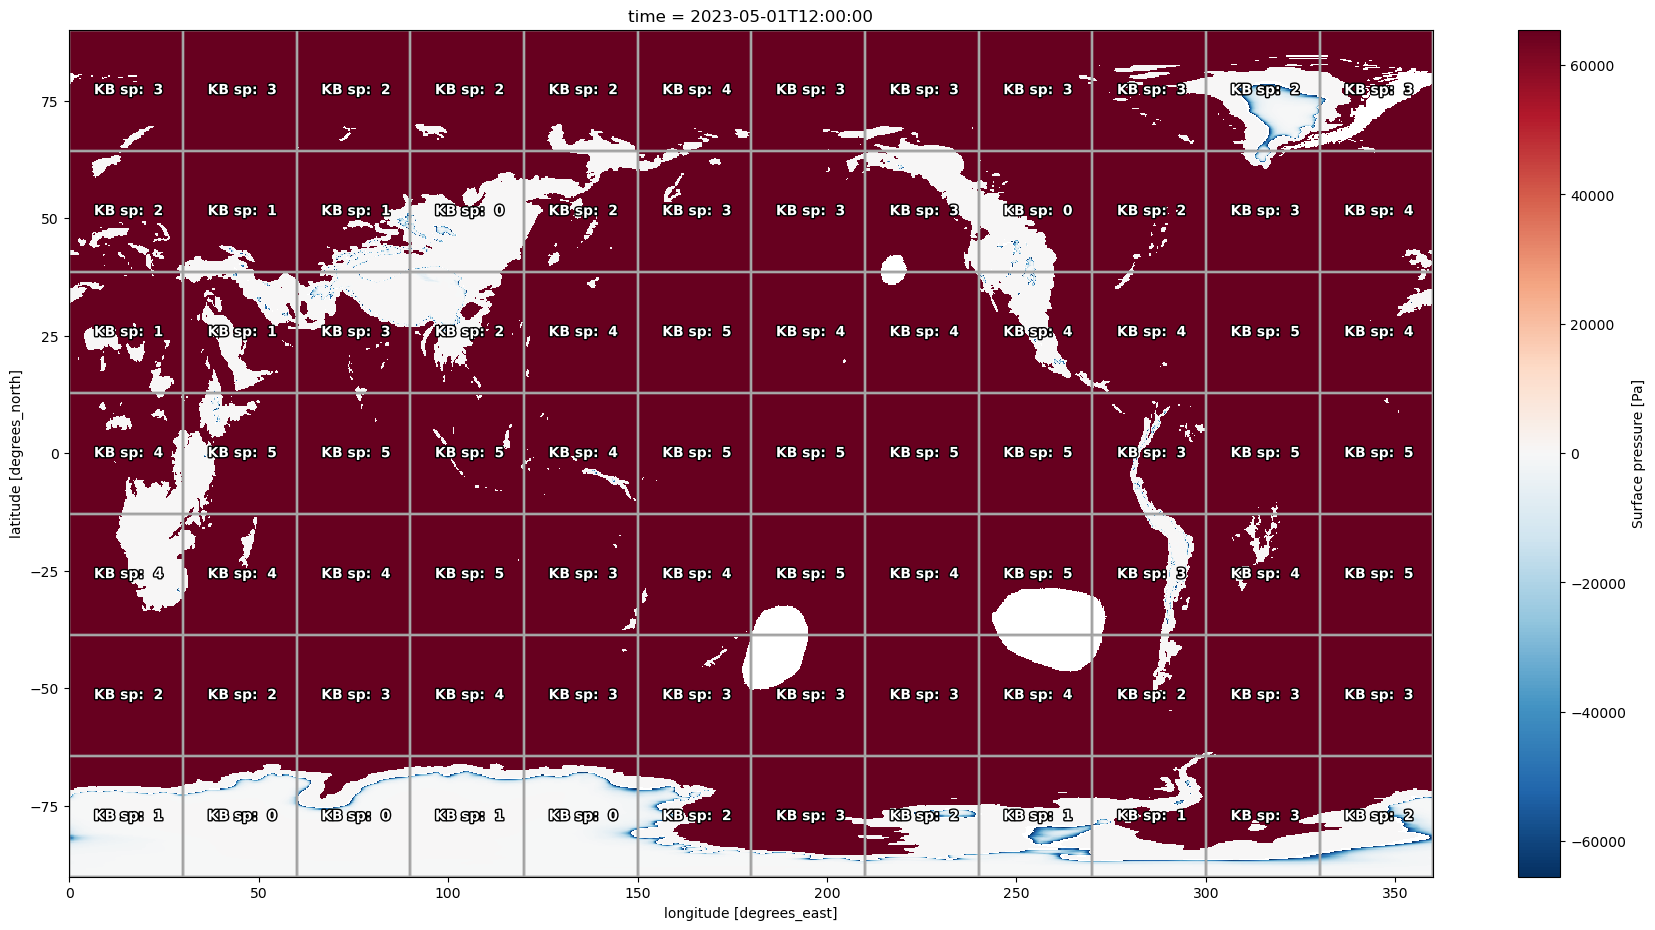

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

fig, ax = plt.subplots(figsize=(22, 11))
        
ds.isel(time=0)['sp'].plot(ax=ax)

for i in range(len(dss_bitrounded)):
    x = float(min(dss[i].longitude[0], dss[i].longitude[-1]))
    y = float(min(dss[i].latitude[0], dss[i].latitude[-1]))
    w = float(abs(dss[i].longitude[0] - dss[i].longitude[-1]))
    h = float(abs(dss[i].latitude[0] - dss[i].latitude[-1]))
    rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                facecolor = "none", edgecolor = "darkgray",
                                path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                label='xxx')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/2.0
    ax.annotate(
        f"""
        KB sp: {int(dss_kbits[i].sp):2}
        """,
        # I: X{ratios[i]['comp']}
        # II: X{ratios[i]['bitr_comp']}
        # """,
        (cx+10, cy), color='w', weight='bold', fontsize=10, ha='right', va='center',
        path_effects=[pe.withStroke(linewidth=2, foreground='k')]
    )

fig.show()